In [1]:
import zipfile
import os
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Dense, Flatten, BatchNormalization, Activation
from tensorflow.keras.models import Model
import sys
import copy
import requests
from io import BytesIO

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 575ms/step


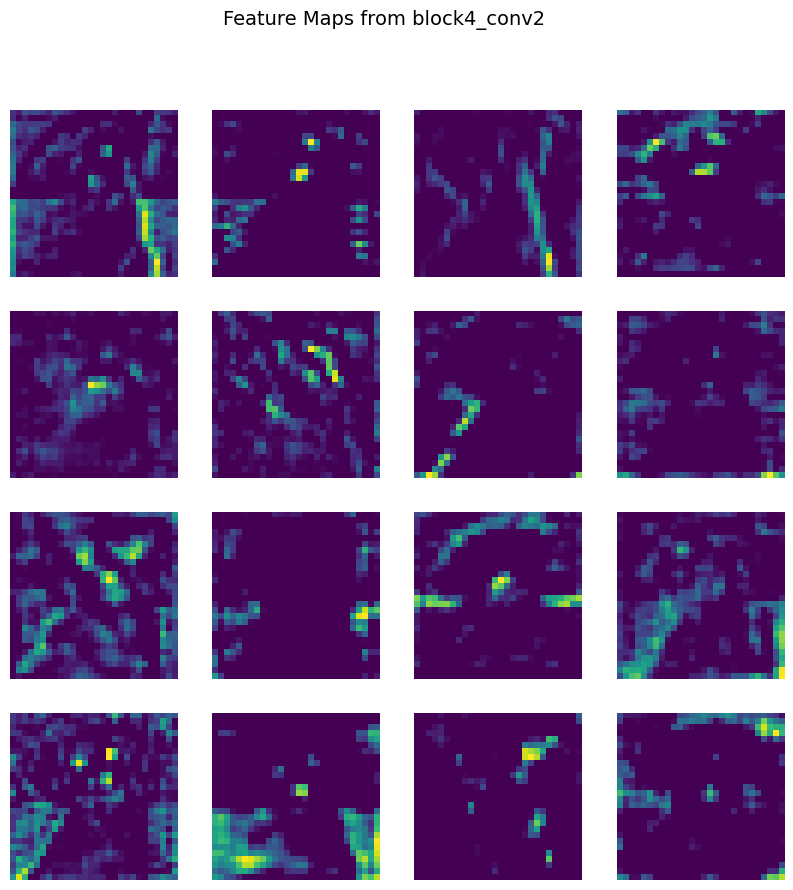

In [22]:
# Code to Visualize Feature Maps

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.applications import vgg19
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing import image

# Function to preprocess the image
def load_and_preprocess_image(img_path, target_size=(224, 224)):
    img = image.load_img(img_path, target_size=target_size)
    img = image.img_to_array(img)
    img = np.expand_dims(img, axis=0)  # Add batch dimension
    img = vgg19.preprocess_input(img)  # Normalize for VGG19
    return img

# Function to display feature maps
def visualize_feature_maps(model, img_path, layer_name):
    img = load_and_preprocess_image(img_path)

    # Extracting the outputs from the chosen layer
    intermediate_model = Model(inputs=model.input, outputs=model.get_layer(layer_name).output)
    feature_maps = intermediate_model.predict(img)

    # Reshape and visualize feature maps
    num_maps = min(16, feature_maps.shape[-1])  # Show up to 16 feature maps
    fig, axes = plt.subplots(4, 4, figsize=(10, 10))

    for i, ax in enumerate(axes.flat):
        if i < num_maps:
            ax.imshow(feature_maps[0, :, :, i], cmap='viridis')
            ax.axis('off')

    plt.suptitle(f"Feature Maps from {layer_name}", fontsize=14)
    plt.show()

# Load pre-trained VGG19 model
base_model = vgg19.VGG19(weights='imagenet', include_top=False)

# Image path (replace with your own image)
image_path = "/content/Golden-Retriever.jpg"

# Choose a content-related layer (e.g., block4_conv2)
visualize_feature_maps(base_model, image_path, "block4_conv2")


80134624/80134624 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
Iteration 0, Loss: 1278578688.0
Iteration 100, Loss: 837411712.0
Iteration 200, Loss: 829130496.0
Iteration 300, Loss: 837657344.0
Iteration 400, Loss: 820799872.0
Iteration 500, Loss: 837004032.0
Iteration 600, Loss: 819437696.0
Iteration 700, Loss: 819611648.0
Iteration 800, Loss: 825710464.0
Iteration 900, Loss: 816814848.0
Iteration 1000, Loss: 823465856.0
Iteration 1100, Loss: 818276992.0
Iteration 1200, Loss: 822476928.0
Iteration 1300, Loss: 834305408.0
Iteration 1400, Loss: 816609088.0
Iteration 1500, Loss: 815921536.0
Iteration 1600, Loss: 823790848.0
Iteration 1700, Loss: 815239936.0
Iteration 1800, Loss: 815301184.0
Iteration 1900, Loss: 824980992.0


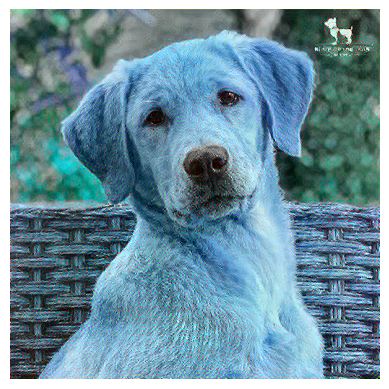

In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.applications import vgg19
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing import image
import time

# Load and preprocess image
def load_and_process_img(img_path, target_size=(512, 512)):
    img = image.load_img(img_path, target_size=target_size)
    img = image.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = vgg19.preprocess_input(img)  # Normalize for VGG19
    return img

# Convert image back to displayable format
def deprocess_img(img):
    img = img.reshape((img.shape[1], img.shape[2], 3))
    img[:, :, 0] += 103.939
    img[:, :, 1] += 116.779
    img[:, :, 2] += 123.68
    img = np.clip(img, 0, 255).astype('uint8')
    return img

# Define content and style layers
CONTENT_LAYER = 'block4_conv2'
STYLE_LAYERS = ['block1_conv1', 'block2_conv1', 'block3_conv1', 'block4_conv1', 'block5_conv1']

# Load VGG19 model
def get_model():
    vgg = vgg19.VGG19(weights='imagenet', include_top=False)
    vgg.trainable = False  # Freeze model

    # Extract outputs from the chosen layers
    content_output = vgg.get_layer(CONTENT_LAYER).output
    style_outputs = [vgg.get_layer(layer).output for layer in STYLE_LAYERS]

    return Model(inputs=vgg.input, outputs=[content_output] + style_outputs)

# Compute content loss (MSE between content and generated image)
def compute_content_loss(content, generated):
    return tf.reduce_mean(tf.square(content - generated))

# Compute Gram matrix for style representation
def gram_matrix(tensor):
    channels = int(tensor.shape[-1])
    vectorized = tf.reshape(tensor, [-1, channels])  # Flatten spatial dimensions
    return tf.matmul(tf.transpose(vectorized), vectorized) / tf.cast(tf.shape(vectorized)[0], tf.float32)

# Compute style loss (Gram matrix difference)
def compute_style_loss(style, generated):
    style_gram = gram_matrix(style)
    generated_gram = gram_matrix(generated)
    return tf.reduce_mean(tf.square(style_gram - generated_gram))

# Compute total loss
def compute_loss(model, content_image, style_image, generated_image, alpha=1e4, beta=1e-2):
    content_features = model(content_image)[0]
    style_features = model(style_image)[1:]
    generated_features = model(generated_image)

    # Compute content loss
    content_loss = compute_content_loss(content_features, generated_features[0])

    # Compute style loss (sum over all chosen layers)
    style_loss = tf.add_n([compute_style_loss(style, gen) for style, gen in zip(style_features, generated_features[1:])])

    # Total loss = weighted sum of content and style loss
    total_loss = alpha * content_loss + beta * style_loss
    return total_loss

# Load images
content_path = '/content/dog.jpg'  # Replace with your content image path
style_path = '/content/painting.jpg'  # Replace with your style image path

content_img = load_and_process_img(content_path)
style_img = load_and_process_img(style_path)

# Initialize generated image as a copy of content image
generated_img = tf.Variable(tf.identity(content_img), dtype=tf.float32)

# Load model
model = get_model()

# Define optimizer
optimizer = tf.optimizers.Adam(learning_rate=5.0)

# Training loop
epochs = 2000
for i in range(epochs):
    with tf.GradientTape() as tape:
        loss = compute_loss(model, content_img, style_img, generated_img)
    gradients = tape.gradient(loss, generated_img)
    optimizer.apply_gradients([(gradients, generated_img)])

    # Clip values to maintain valid image range
    generated_img.assign(tf.clip_by_value(generated_img, -128, 128))

    if i % 100 == 0:  # Print progress every 100 iterations
        print(f"Iteration {i}, Loss: {loss.numpy()}")

# Display final image
final_img = deprocess_img(generated_img.numpy())
plt.imshow(final_img)
plt.axis('off')
plt.show()
